# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '26'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_snow.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2528737)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 10:06:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qs   = xr.open_dataset(fname).q_snow.values
    ns   = xr.open_dataset(fname).n_snow.values
    ni   = xr.open_dataset(fname).n_ice.values
    cwc  = xr.open_dataset(fname).cwc.values    
    # process rates
    self_snow_num  = xr.open_dataset(fname).self_snow.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-2
    ns = np.log(ns, where=ns>n_min, out=np.nan*ns)
    qs = np.log(qs, where=qs>q_min, out=np.nan*qs)
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    self_snow  = np.where(self_snow_num>p_min,1,0)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qs, ns, ni, temp, rho, self_snow ]))
    dataset = dataset.T
    dataset.columns = [ 'qs', 'ns', 'ni', 'temp', 'rho', 'self_snow' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


### Separate in training, validation and test data 70/15/15

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qs        ns         ni        temp    rho  self_snow
1 -12.460861  6.875232  11.622676  243.710007  0.699        0.0
2 -12.225215  7.100027  11.618186  243.779999  0.700        0.0
3 -12.022685  7.286192  11.613495  243.850006  0.701        0.0
5 -11.743698  7.545390  11.605140  244.000000  0.703        0.0
7 -11.550067  7.738924  11.597083  244.139999  0.705        0.0

In [10]:
dataset_train.describe()

qs            ns            ni          temp           rho  \
count  1.735604e+06  1.735604e+06  1.735604e+06  1.735604e+06  1.735604e+06   
mean  -8.960843e+00  1.080110e+01  1.341926e+01  2.406841e+02  6.796455e-01   
std    2.720588e+00  2.972249e+00  4.222009e+00  1.295463e+01  1.580898e-01   
min   -2.302575e+01 -1.449861e+01 -1.446784e+01  2.066900e+02  4.120000e-01   
25%   -1.008843e+01  9.973014e+00  1.200267e+01  2.312300e+02  5.590000e-01   
50%   -8.531900e+00  1.141754e+01  1.418852e+01  2.405100e+02  6.630000e-01   
75%   -7.156293e+00  1.264504e+01  1.623694e+01  2.490500e+02  7.680000e-01   
max   -4.012009e+00  1.607404e+01  2.052169e+01  2.738200e+02  1.288000e+00   

          self_snow  
count  1.735604e+06  
mean   6.415092e-01  
std    4.795574e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    1.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

In [11]:
dataset_test.describe()

qs             ns             ni           temp  \
count  371628.000000  371628.000000  371628.000000  371628.000000   
mean       -8.953418      10.815593      13.436864     240.658689   
std         2.704089       2.957541       4.200061      12.928765   
min       -23.025650     -14.467842     -14.467842     207.110001   
25%       -10.081586       9.982461      12.009053     231.210007   
50%        -8.529519      11.421917      14.195043     240.500000   
75%        -7.156781      12.649612      16.246929     249.020004   
max        -4.012064      16.027765      20.517300     273.769989   

                 rho      self_snow  
count  371628.000000  371628.000000  
mean        0.679237       0.642158  
std         0.157680       0.479366  
min         0.412000       0.000000  
25%         0.559000       0.000000  
50%         0.663000       1.000000  
75%         0.768000       1.000000  
max         1.284000       1.000000

In [12]:
dataset_val.describe()

qs             ns             ni           temp  \
count  372596.000000  372596.000000  372596.000000  372596.000000   
mean       -8.956043      10.800477      13.420084     240.686948   
std         2.720281       2.976764       4.217037      12.934751   
min       -23.025551     -14.467842     -14.467842     206.619995   
25%       -10.077532       9.973235      12.006096     231.229996   
50%        -8.527800      11.417301      14.190379     240.539993   
75%        -7.156153      12.646204      16.233499     249.029999   
max        -4.011843      15.962354      20.521088     273.779999   

                 rho      self_snow  
count  372596.000000  372596.000000  
mean        0.679665       0.642540  
std         0.157849       0.479252  
min         0.412000       0.000000  
25%         0.559000       0.000000  
50%         0.663000       1.000000  
75%         0.768000       1.000000  
max         1.286000       1.000000

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['qs'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qs            ns            ni          temp           rho  \
count  1.719206e+06  1.719206e+06  1.719206e+06  1.719206e+06  1.719206e+06   
mean  -8.841667e+00  1.091570e+01  1.352017e+01  2.404318e+02  6.762221e-01   
std    2.441645e+00  2.740891e+00  4.097829e+00  1.274468e+01  1.546145e-01   
min   -1.999998e+01 -1.446784e+01 -1.446784e+01  2.066900e+02  4.120000e-01   
25%   -1.002808e+01  1.002959e+01  1.207460e+01  2.311200e+02  5.580000e-01   
50%   -8.506699e+00  1.143987e+01  1.422523e+01  2.403600e+02  6.610000e-01   
75%   -7.142541e+00  1.265833e+01  1.625559e+01  2.487600e+02  7.640000e-01   
max   -4.012009e+00  1.607404e+01  2.052169e+01  2.738200e+02  1.288000e+00   

          self_snow  
count  1.719206e+06  
mean   6.476280e-01  
std    4.777092e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    1.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

In [16]:
dataset_test.describe()

qs             ns             ni           temp  \
count  368237.000000  368237.000000  368237.000000  368237.000000   
mean       -8.838350      10.926186      13.533452     240.413897   
std         2.433350       2.733449       4.080766      12.722863   
min       -19.999977     -14.467842     -14.467842     207.110001   
25%       -10.024504      10.038980      12.079375     231.110001   
50%        -8.504820      11.443618      14.229737     240.360001   
75%        -7.143313      12.661565      16.263062     248.740005   
max        -4.012064      16.027765      20.517300     273.769989   

                 rho      self_snow  
count  368237.000000  368237.000000  
mean        0.675903       0.648072  
std         0.154247       0.477572  
min         0.412000       0.000000  
25%         0.558000       0.000000  
50%         0.661000       1.000000  
75%         0.764000       1.000000  
max         1.284000       1.000000

### Pairplot

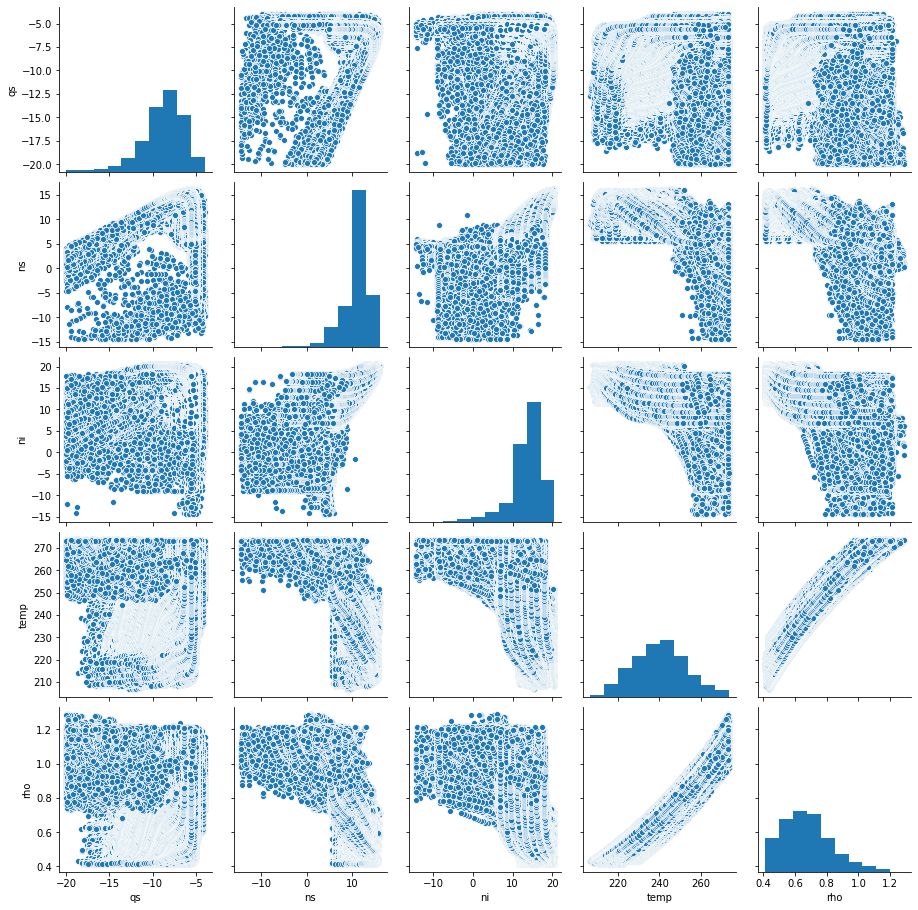

In [17]:
sns.pairplot(dataset_train[["qs","ns","ni","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [21]:
train_dataset1 = train_dataset1.drop(['ni'], axis=1)
train_dataset2 = train_dataset2.drop(['rho','temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ni'], axis=1)

In [22]:
test_dataset1 = test_dataset1.drop(['ni'], axis=1)
test_dataset2 = test_dataset2.drop(['rho','temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ni'], axis=1)

In [23]:
val_dataset1 = val_dataset1.drop(['ni'], axis=1)
val_dataset2 = val_dataset2.drop(['rho','temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ni'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self_snow")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean        std         min         25%         50%  \
qs    1719206.0   -8.841667   2.441645  -19.999977  -10.028076   -8.506699   
ns    1719206.0   10.915695   2.740891  -14.467842   10.029592   11.439871   
temp  1719206.0  240.431768  12.744685  206.690002  231.119995  240.360001   
rho   1719206.0    0.676222   0.154614    0.412000    0.558000    0.661000   

             75%         max  
qs     -7.142541   -4.012009  
ns     12.658326   16.074039  
temp  248.759995  273.820007  
rho     0.764000    1.288000

In [25]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self_snow")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
qs  1719206.0  -8.841667  2.441645 -19.999977 -10.028076  -8.506699   
ns  1719206.0  10.915695  2.740891 -14.467842  10.029592  11.439871   
ni  1719206.0  13.520168  4.097829 -14.467842  12.074596  14.225233   

          75%        max  
qs  -7.142541  -4.012009  
ns  12.658326  16.074039  
ni  16.255594  20.521688

In [26]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self_snow")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qs    1719206.0   -8.841667   2.441645  -19.999977  -10.028076   -8.506699   
ns    1719206.0   10.915695   2.740891  -14.467842   10.029592   11.439871   
ni    1719206.0   13.520168   4.097829  -14.467842   12.074596   14.225233   
temp  1719206.0  240.431768  12.744685  206.690002  231.119995  240.360001   
rho   1719206.0    0.676222   0.154614    0.412000    0.558000    0.661000   

             75%         max  
qs     -7.142541   -4.012009  
ns     12.658326   16.074039  
ni     16.255594   20.521688  
temp  248.759995  273.820007  
rho     0.764000    1.288000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['self_snow']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [30]:
train_labels.describe()

self_snow
count  1.719206e+06
mean   6.476280e-01
std    4.777092e-01
min    0.000000e+00
25%    0.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00

In [31]:
train_dataset1.describe()

qs            ns          temp           rho
count  1.719206e+06  1.719206e+06  1.719206e+06  1.719206e+06
mean  -8.841667e+00  1.091570e+01  2.404318e+02  6.762221e-01
std    2.441645e+00  2.740891e+00  1.274468e+01  1.546145e-01
min   -1.999998e+01 -1.446784e+01  2.066900e+02  4.120000e-01
25%   -1.002808e+01  1.002959e+01  2.311200e+02  5.580000e-01
50%   -8.506699e+00  1.143987e+01  2.403600e+02  6.610000e-01
75%   -7.142541e+00  1.265833e+01  2.487600e+02  7.640000e-01
max   -4.012009e+00  1.607404e+01  2.738200e+02  1.288000e+00

In [32]:
train_dataset2.describe()

qs            ns            ni
count  1.719206e+06  1.719206e+06  1.719206e+06
mean  -8.841667e+00  1.091570e+01  1.352017e+01
std    2.441645e+00  2.740891e+00  4.097829e+00
min   -1.999998e+01 -1.446784e+01 -1.446784e+01
25%   -1.002808e+01  1.002959e+01  1.207460e+01
50%   -8.506699e+00  1.143987e+01  1.422523e+01
75%   -7.142541e+00  1.265833e+01  1.625559e+01
max   -4.012009e+00  1.607404e+01  2.052169e+01

In [33]:
train_dataset3.describe()

qs            ns            ni          temp           rho
count  1.719206e+06  1.719206e+06  1.719206e+06  1.719206e+06  1.719206e+06
mean  -8.841667e+00  1.091570e+01  1.352017e+01  2.404318e+02  6.762221e-01
std    2.441645e+00  2.740891e+00  4.097829e+00  1.274468e+01  1.546145e-01
min   -1.999998e+01 -1.446784e+01 -1.446784e+01  2.066900e+02  4.120000e-01
25%   -1.002808e+01  1.002959e+01  1.207460e+01  2.311200e+02  5.580000e-01
50%   -8.506699e+00  1.143987e+01  1.422523e+01  2.403600e+02  6.610000e-01
75%   -7.142541e+00  1.265833e+01  1.625559e+01  2.487600e+02  7.640000e-01
max   -4.012009e+00  1.607404e+01  2.052169e+01  2.738200e+02  1.288000e+00

### Normalize the features

In [34]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [35]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qs    1719206.0 -1.428355e-16  1.0 -4.569998 -0.485906  0.137190  0.695894   
ns    1719206.0  1.333048e-15  1.0 -9.261053 -0.323290  0.191243  0.635790   
temp  1719206.0 -2.396462e-16  1.0 -2.647517 -0.730640 -0.005631  0.653467   
rho   1719206.0 -9.945580e-17  1.0 -1.708909 -0.764625 -0.098452  0.567721   

           max  
qs    1.978035  
ns    1.881995  
temp  2.619778  
rho   3.956796

In [36]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qs  1719206.0 -1.428355e-16  1.0 -4.569998 -0.485906  0.137190  0.695894   
ns  1719206.0  1.333048e-15  1.0 -9.261053 -0.323290  0.191243  0.635790   
ni  1719206.0 -1.195057e-15  1.0 -6.829961 -0.352765  0.172058  0.667531   

         max  
qs  1.978035  
ns  1.881995  
ni  1.708593

In [37]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qs    1719206.0 -1.428355e-16  1.0 -4.569998 -0.485906  0.137190  0.695894   
ns    1719206.0  1.333048e-15  1.0 -9.261053 -0.323290  0.191243  0.635790   
ni    1719206.0 -1.195057e-15  1.0 -6.829961 -0.352765  0.172058  0.667531   
temp  1719206.0 -2.396462e-16  1.0 -2.647517 -0.730640 -0.005631  0.653467   
rho   1719206.0 -9.945580e-17  1.0 -1.708909 -0.764625 -0.098452  0.567721   

           max  
qs    1.978035  
ns    1.881995  
ni    1.708593  
temp  2.619778  
rho   3.956796

# The model

## Build the model

In [38]:

def build_model_relu(ncol):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

def build_model(ncol,activation):
    if activation == "sigm":
        model = build_model_sigm(ncol)
    elif activation == "ReLU":
        model = build_model_relu(ncol)
    else:
        print("Error: Wrong choice for activation")
    return model  

In [39]:
activ = "ReLU"
model = build_model(4,activ)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 930
Trainable params: 930
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [41]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[0.03125554, 0.22089289],
       [0.02666268, 0.20788841],
       [0.021696  , 0.19831745],
       [0.01710814, 0.18515947],
       [0.01439267, 0.1755571 ],
       [0.00956497, 0.16361777],
       [0.00811689, 0.16048518],
       [0.00661516, 0.15817723],
       [0.00551796, 0.15588802],
       [0.00374988, 0.15550296]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [42]:
# maximum number, but we use early stopping
EPOCHS = 300

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [43]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),activ)

early_history1 = model1.fit(normed_train_data1, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9329,  loss:0.1530,  val_accuracy:0.9340,  val_loss:0.1504,  
..........................

Text(0, 0.5, 'accuracy')

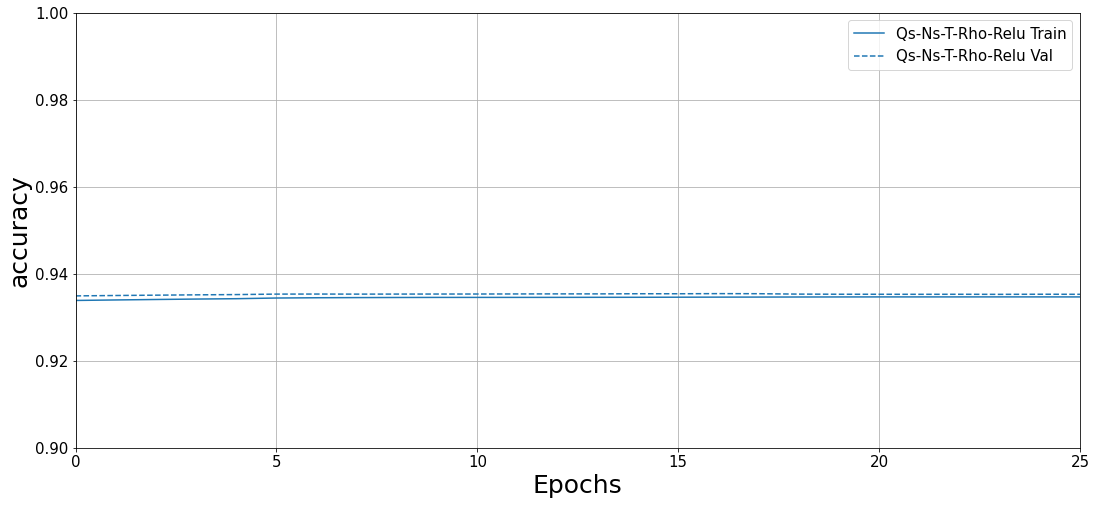

In [44]:
histories['qs-ns-T-rho-ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = 'accuracy')
plt.ylim([0.9, 1.])
plt.ylabel('accuracy')

In [45]:
model2 = build_model(len(normed_train_data2.keys()),activ)

early_history2 = model2.fit(normed_train_data2, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9325,  loss:0.1544,  val_accuracy:0.9335,  val_loss:0.1522,  
................................................................

Text(0, 0.5, 'accuracy')

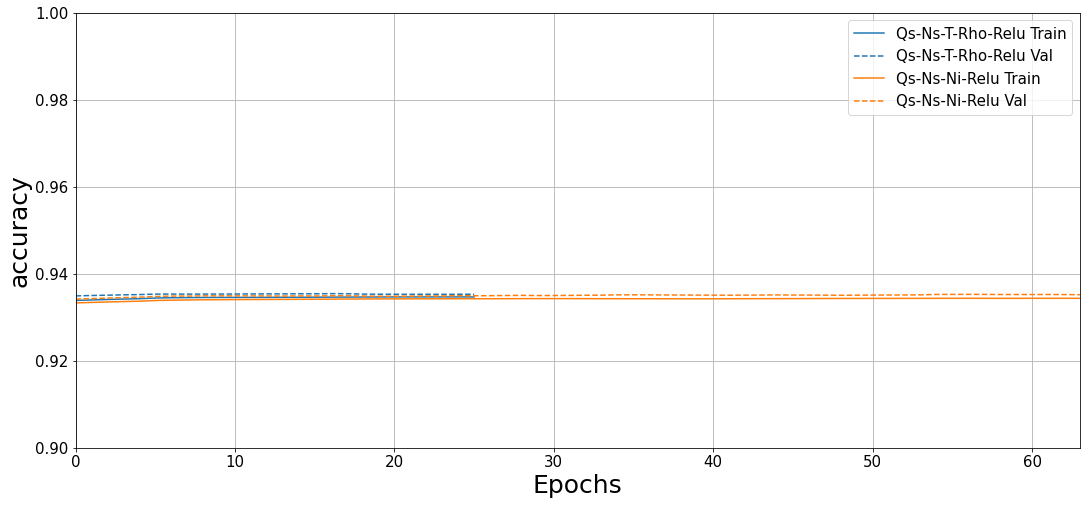

In [46]:
histories['qs-ns-ni-ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "accuracy")
plt.ylim([0.9, 1.0])
plt.ylabel('accuracy')

In [47]:
model3 = build_model(len(normed_train_data3.keys()),activ)

early_history3 = model3.fit(normed_train_data3, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9359,  loss:0.1458,  val_accuracy:0.9365,  val_loss:0.1438,  
..........................

Text(0, 0.5, 'accuracy')

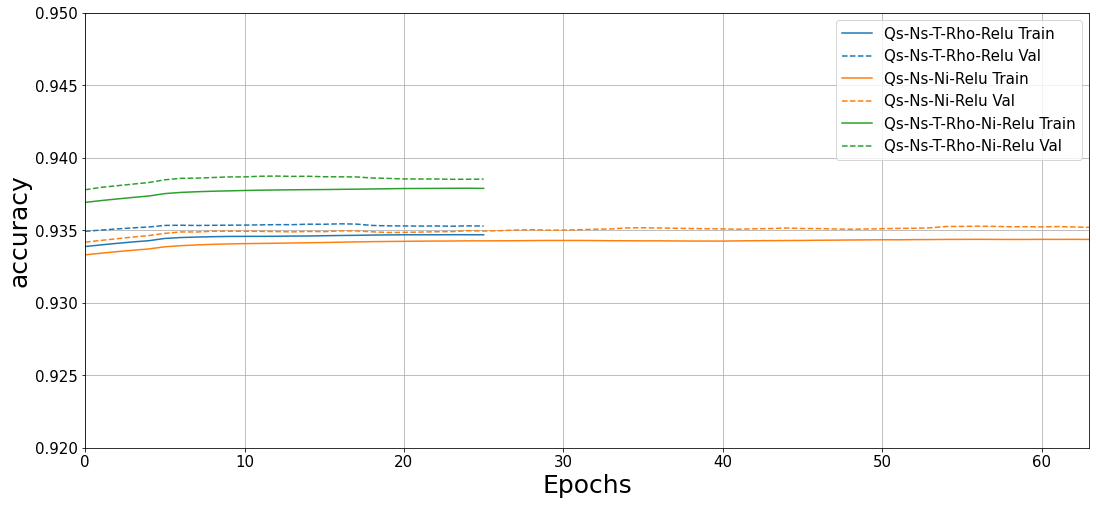

In [48]:
histories['qs-ns-T-rho-ni-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)


plotter.plot(histories, metric = "accuracy")
plt.ylim([0.92, 0.95])
plt.ylabel('accuracy')

In [49]:
loss1, accuracy1 = model1.evaluate(normed_test_data1, test_labels, verbose=2)

print("Testing set for model 1, Accuracy: {:10.5f}".format(accuracy1))

368237/368237 - 9s - loss: 0.1485 - accuracy: 0.9351
Testing set for model 1, Accuracy:    0.93508


In [50]:
loss2, accuracy2 = model2.evaluate(normed_test_data2, test_labels, verbose=2)

print("Testing set for model 2, Accuracy: {:10.5f}".format(accuracy2))

368237/368237 - 9s - loss: 0.1488 - accuracy: 0.9347
Testing set for model 2, Accuracy:    0.93469


In [51]:
loss3, accuracy3 = model3.evaluate(normed_test_data3, test_labels, verbose=2)

print("Testing set for model 3, Accuracy: {:10.5f}".format(accuracy3))

368237/368237 - 9s - loss: 0.1400 - accuracy: 0.9381
Testing set for model 3, Accuracy:    0.93810


In [52]:
scores = [ accuracy1, accuracy2, accuracy3 ]
scores

[0.9350799, 0.9346888, 0.93810236]

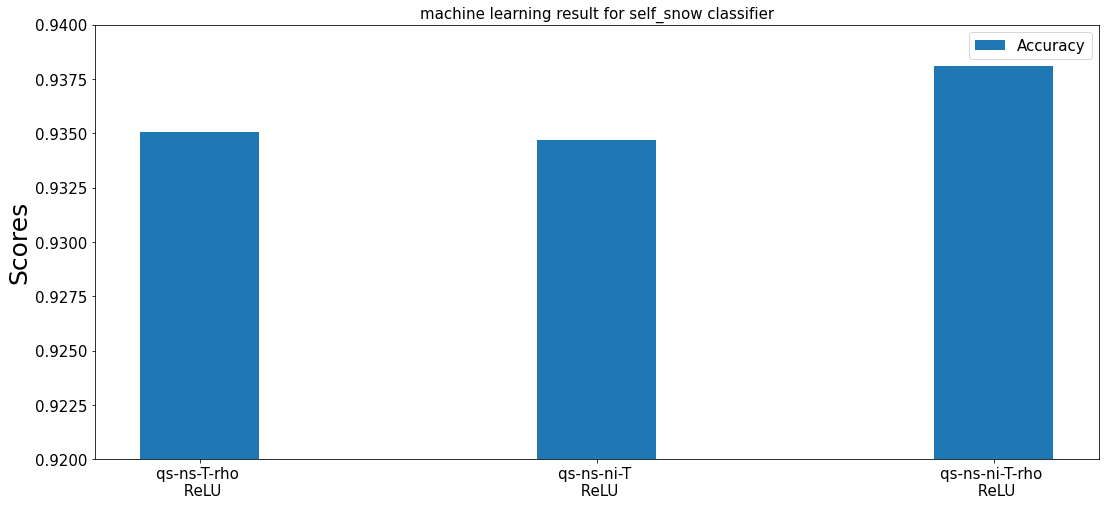

In [53]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['qs-ns-T-rho \n ReLU',
 'qs-ns-ni-T \n ReLU',
 'qs-ns-ni-T-rho \n ReLU' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, scores, width, label='Accuracy')
#rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for self_snow classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.92,0.94)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [54]:
model1.predict(normed_test_data1)

array([[ -0.2758344 ,  -6.297713  ],
       [ -0.30086243,  -4.402045  ],
       [ -0.31219354,  -3.5438058 ],
       ...,
       [  1.6407526 ,  14.248277  ],
       [ -0.17689268, -13.791744  ],
       [ -0.1095838 , -18.889843  ]], dtype=float32)

In [55]:
test_dataset2.head()

qs        ns         ni
0  -12.718099  6.595780  11.626968
4  -11.862312  7.424165  11.609235
8  -11.475919  7.819234  11.593030
9  -11.380320  7.909857  11.588219
17 -10.925973  8.357728  11.554259

In [56]:
normed_test_data2.head()

qs        ns        ni
0  -1.587631 -1.576099 -0.462001
4  -1.237136 -1.273867 -0.466328
8  -1.078884 -1.129728 -0.470283
9  -1.039731 -1.096665 -0.471457
17 -0.853648 -0.933261 -0.479744

In [57]:
p2 = pd.DataFrame(model2.predict(normed_test_data2))

In [58]:
p2.head()

0         1
0  5.169180  0.282222
1  3.900330  0.315046
2  3.421606  0.327431
3  3.339499  0.329555
4  2.775459  0.344146

In [59]:
probability_model1 = tf.keras.Sequential([model1,tf.keras.layers.Softmax()])

In [60]:
data=probability_model1.predict(normed_test_data1)

In [61]:
p1 = pd.DataFrame(data)

In [62]:
p1.describe()

0              1
count  368237.000000  368237.000000
mean        0.356286       0.643714
std         0.427096       0.427096
min         0.000000       0.000000
25%         0.000063       0.101416
50%         0.038133       0.961867
75%         0.898584       0.999937
max         1.000000       1.000000

In [63]:
p1.tail()

0             1
368232  0.000001  9.999987e-01
368233  0.000002  9.999980e-01
368234  0.000003  9.999967e-01
368235  0.999999  1.222206e-06
368236  1.000000  6.979699e-09

# Save models to file

In [64]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [65]:
def save2netcdf(model, features_str, labels_str, features_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for normalization of input data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    
    D.to_netcdf(outpath)

In [66]:
features = 'qs, ns, T, rho'
labels   = 'self_snow'
filename = 'saved_model_v2/self_snow_classifier1_'+version+'.nc'
logtransform = np.array([True, True, False, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,logtransform,filename)

Saving model to saved_model_v2/self_snow_classifier1_26.nc
  Features:   qs, ns, T, rho
  Labels:     self_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [67]:
features = 'qs, ns, ni'
labels   = 'self_snow'
filename = 'saved_model_v2/self_snow_classifier2_'+version+'.nc'
logtransform = np.array([True, True, True], dtype=bool)
save2netcdf(model2,features,labels,train_stats2,logtransform,filename)

Saving model to saved_model_v2/self_snow_classifier2_26.nc
  Features:   qs, ns, ni
  Labels:     self_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [68]:
features = 'qs, ns, ni, T, rho'
labels   = 'self_snow'
filename = 'saved_model_v2/self_snow_classifier3_'+version+'.nc'
logtransform = np.array([True, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,logtransform,filename)

Saving model to saved_model_v2/self_snow_classifier3_26.nc
  Features:   qs, ns, ni, T, rho
  Labels:     self_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear
